In [1]:
!pip install --upgrade pip
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install jax
!pip install jaxlib diffusers huggingface_hub flax transformers
!pip install orbax-checkpoint
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.2
    Uninstalling huggingface-hub-0.20.2:
      Successfully uninstalled huggingface-hub-0.20.2


In [2]:
from diffusers import FlaxUNet2DConditionModel
from IPython.display import clear_output

diff_unet = FlaxUNet2DConditionModel.from_pretrained('/kaggle/input/sdxl-unet')
clear_output(wait=False) # Clear the loading messages
unet_module = diff_unet[0] # Extract the Flax Module
unet_variables = {'params': diff_unet[1]} # Extract the parameters

print(unet_variables.keys())
unet_module

dict_keys(['params'])


FlaxUNet2DConditionModel(
    # attributes
    sample_size = 128
    in_channels = 4
    out_channels = 4
    down_block_types = ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']
    up_block_types = ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']
    only_cross_attention = False
    block_out_channels = [320, 640, 1280]
    layers_per_block = 2
    attention_head_dim = [5, 10, 20]
    num_attention_heads = None
    cross_attention_dim = 2048
    dropout = 0.0
    use_linear_projection = True
    dtype = float32
    flip_sin_to_cos = True
    freq_shift = 0
    use_memory_efficient_attention = False
    split_head_dim = False
    transformer_layers_per_block = [1, 2, 10]
    addition_embed_type = 'text_time'
    addition_time_embed_dim = 256
    addition_embed_type_num_heads = 64
    projection_class_embeddings_input_dim = 2816
)

In [3]:
import jax
import numpy as np
import jax.numpy as jnp
import orbax.checkpoint

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
import transformers
import time
from diffusers.utils import make_image_grid
from huggingface_hub import hf_hub_download

In [4]:
# !wget https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/vae/diffusion_flax_model.msgpack?download=true
# !mv diffusion_flax_model.msgpack?download=true diffusion_flax_model.msgpack

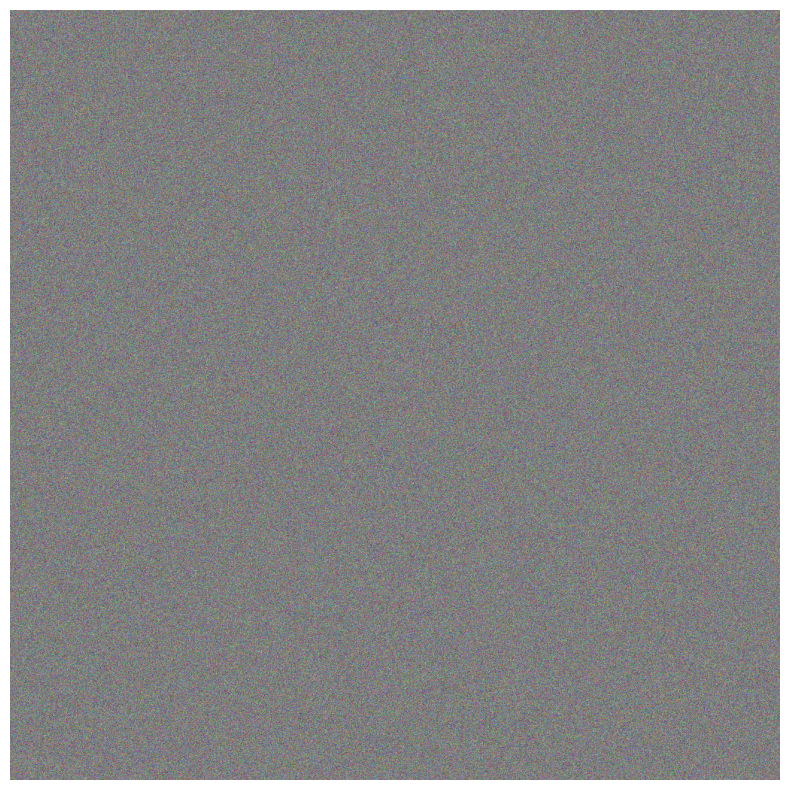

In [5]:
figsize=(10,10)
key = jax.random.PRNGKey(42)
test_image = jax.random.normal(key, shape=(1024,1024, 3))
test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(test_image)


# from PIL import Image
# from diffusers.utils import numpy_to_pil
# img = numpy_to_pil(np.array(test_image))
# make_image_grid(img, 1, 1)

In [6]:
# from flax import linen as nn  # Linen API

# class CNN(nn.Module):
#     """A simple CNN model."""

#     @nn.compact
#     def __call__(self, x):
#         x = nn.Conv(features=32, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = nn.Conv(features=64, kernel_size=(3, 3))(x)
#         x = nn.relu(x)
#         x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
#         x = x.reshape((x.shape[0], -1))  # flatten
#         x = nn.Dense(features=256)(x)
#         x = nn.relu(x)
#         x = nn.Dense(features=10)(x)
#         return x

# cnn = CNN()
# print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1))))

In [7]:
from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
tokenizer_2 = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')

tokenizer_config.json: 100%|██████████| 568/568 [00:00<00:00, 2.21MB/s]
vocab.json: 100%|██████████| 862k/862k [00:00<00:00, 14.6MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 53.8MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<00:00, 2.05MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:00<00:00, 11.6MB/s]
config.json: 100%|██████████| 4.19k/4.19k [00:00<00:00, 20.4MB/s]


In [8]:
from transformers import FlaxCLIPTextModel, FlaxCLIPTextModelWithProjection
text_encoder_1 = FlaxCLIPTextModel.from_pretrained('/kaggle/input/sdxl-text-encoder-1')
text_encoder_2 = FlaxCLIPTextModelWithProjection.from_pretrained('/kaggle/input/text-encoder-2')

In [9]:
from diffusers import FlaxAutoencoderKL
from IPython.display import clear_output

diff_vae = FlaxAutoencoderKL.from_pretrained('/kaggle/input/sdxl-vae-model/')
clear_output(wait=False) # Clear the loading messages
vae_module = diff_vae[0] # Extract the Flax Module
vae_variables = {'params': diff_vae[1]} # Extract the parameters

print(vae_variables.keys())
vae_module

dict_keys(['params'])


FlaxAutoencoderKL(
    # attributes
    in_channels = 3
    out_channels = 3
    down_block_types = ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D']
    up_block_types = ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']
    block_out_channels = [128, 256, 512, 512]
    layers_per_block = 2
    act_fn = 'silu'
    latent_channels = 4
    norm_num_groups = 32
    sample_size = 1024
    scaling_factor = 0.13025
    dtype = float32
)

In [10]:
from diffusers import FlaxEulerDiscreteScheduler
scheduler = FlaxEulerDiscreteScheduler.from_pretrained('/kaggle/input/sdxl-scheduler/config.json')
scheduler_module = scheduler[0]
scheduler_params = scheduler[1]

In [11]:
vae_scale_factor = 2 ** (len(vae_module.config.block_out_channels) - 1)
height = unet_module.config.sample_size * vae_scale_factor
width = unet_module.config.sample_size * vae_scale_factor

In [12]:
guidance_scale = 5.0
num_steps = 25
default_seed = 33

NameError: name 'text_encoder_1' is not defined

## **Function to Generate Image**

In [13]:
@partial(
    jax.pmap,
    in_axes=(0, 0, 0, None, None),
    static_broadcasted_argnums=(3,4),
)
# @jax.jit
def generate_image(
    positive_input_ids,
    negative_input_ids=None,
    prng_seed=jax.random.PRNGKey(42),
    guidance_scale=5.0,
    num_inference_steps=50,
):
    
    
    def get_embeddings(prompt_ids):
        te_1_inputs = prompt_ids[:, 0, :]
        te_2_inputs = prompt_ids[:, 1, :]
        
        prompt_embeds_1 = text_encoder_1(te_1_inputs,params=text_encoder_1.params, output_hidden_states=True)["hidden_states"][-2]
        prompt_embeds_2 = text_encoder_2(te_2_inputs,params=text_encoder_2.params, output_hidden_states=True)["hidden_states"][-2]

        prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)
        pooled_embeds = text_encoder_2(te_2_inputs,params=text_encoder_2.params, output_hidden_states=True)["text_embeds"]
        
        return prompt_embeds, pooled_embeds
    
    positive_prompt_embeds, positive_pooled_embeds = get_embeddings(positive_input_ids)
    batch_size = positive_prompt_embeds.shape[0]
    
    if negative_input_ids is None:
        negative_prompt_embeds = jnp.zeros_like(positive_prompt_embeds)
        negative_pooled_embeds = jnp.zeros_like(positive_pooled_embeds)
    else:       
        negative_prompt_embeds, negative_pooled_embeds = get_embeddings(negative_input_ids)
        
    prompt_embeds = jnp.concatenate([negative_prompt_embeds, positive_prompt_embeds], axis=0)  # (2, 77, 2048)
#     print(prompt_embeds.shape)
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    latents_shape = (
                batch_size,
                unet_module.config.in_channels,
                height // vae_scale_factor,
                width // vae_scale_factor,
            )
    
    latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
    scheduler_state = scheduler_module.set_timesteps(scheduler_params, num_inference_steps=num_steps, shape=latents.shape)
    latents = latents * scheduler_state.init_noise_sigma
    
#     print(latents.shape)
    
    def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids
    
    add_time_ids = _get_add_time_ids(
        (height, width), (0, 0), (height, width), positive_prompt_embeds.shape[0], dtype=positive_prompt_embeds.dtype
    )
    
    add_text_embeds = jnp.concatenate([negative_pooled_embeds, positive_pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)
    
    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
#     print(prompt_embeds.shape)
    def loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)

        # predict the noise residual
        noise_pred = unet_module.apply(
            unet_variables,
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state
    
    latents, _ = jax.lax.fori_loop(0, num_steps, loop_body, (latents, scheduler_state))
    latents = 1 / vae_module.config.get("scaling_factor") * latents
    
    image = vae_module.apply(vae_variables, latents, method=vae_module.decode).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    
    return image

In [14]:
def tokenise_prompts(prompt):
    inputs = []
    for tokenizer in [tokenizer_1, tokenizer_2]:
        text_inputs = tokenizer(
            positive_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
    inputs.append(text_inputs.input_ids)
    return jnp.stack(inputs, axis=1)

Compiled in 437.96028113365173


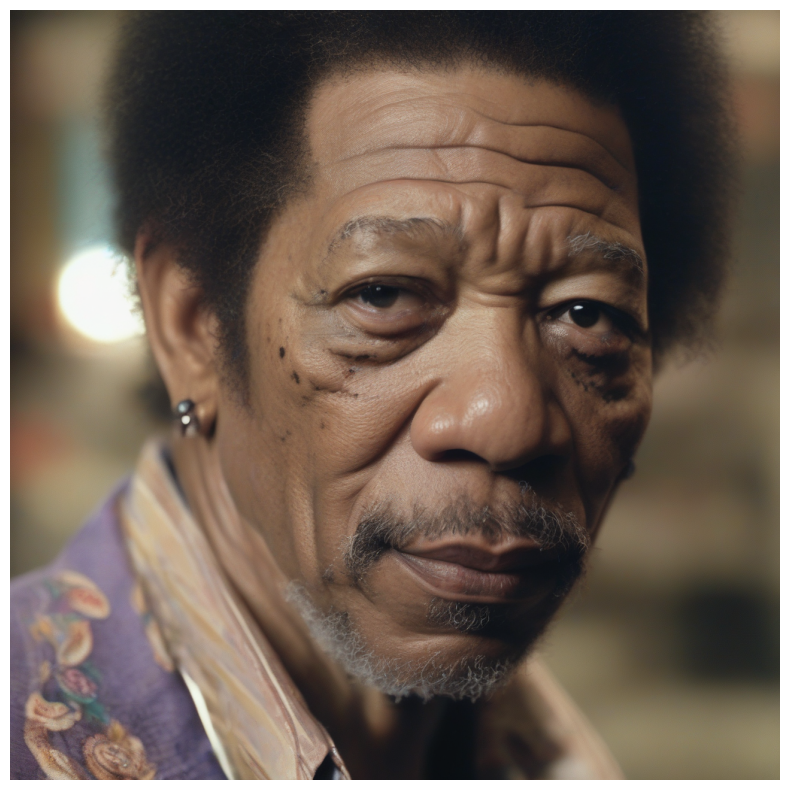

In [15]:
positive_prompt = "A cinematic film still of Morgan Freeman starring as Jimi Hendrix, portrait, 80mm lens, shallow depth of field, close up, split lighting, cinematic"
# negative_prompt = None
prng_seed = replicate(jax.random.PRNGKey(default_seed))
positive_input_ids = replicate(tokenise_prompts(positive_prompt))
print("Start Compiling")
start = time.time()
gen_image = generate_image(positive_input_ids,None,prng_seed,guidance_scale,num_steps)
print(f"Compiled in {time.time() - start}")
figsize=(10,10)
# key = jax.random.PRNGKey(42)
# test_image = jax.random.normal(key, shape=(1024,1024, 3))
# test_image = (255*((test_image - test_image.min())/(test_image.max() - test_image.min()))).round().astype("uint8")

plt.figure(figsize=figsize)
plt.axis('off')
# plt.imshow(gen_image.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))
plt.imshow(gen_image[1][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

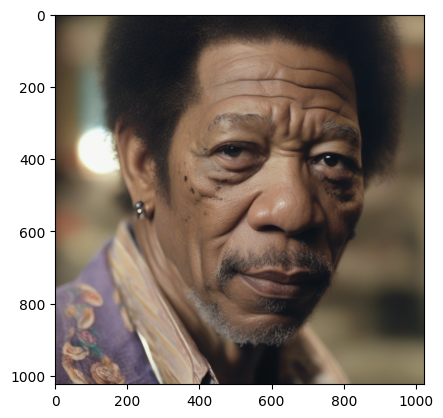

In [16]:
plt.imshow(gen_image[7][0]) #.reshape(gen_image.shape[1],gen_image.shape[2],gen_image.shape[3]))

In [17]:
sfrg 

NameError: name 'sfrg' is not defined

# Old Code

In [ ]:
inputs = []
positive_prompt = "Dog jumping over hedge"
negative_prompt = None
for tokenizer in [tokenizer_1, tokenizer_2]:
    text_inputs = tokenizer(
        positive_prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="np",
    )
    inputs.append(text_inputs.input_ids)
positive_inputs = jnp.stack(inputs, axis=1)
positive_inputs

In [ ]:
te_1_inputs = positive_inputs[:, 0, :]
te_2_inputs = positive_inputs[:, 1, :]

In [ ]:
prompt_embeds_1 = text_encoder_1(te_1_inputs,params=text_encoder_1.params, output_hidden_states=True)["hidden_states"][-2]
prompt_embeds_2 = text_encoder_2(te_2_inputs,params=text_encoder_2.params, output_hidden_states=True)["hidden_states"][-2]

pooled_embeds = text_encoder_2(te_2_inputs,params=text_encoder_2.params, output_hidden_states=True)["text_embeds"]

prompt_embeds = jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1)

In [ ]:
print(prompt_embeds_1.shape)
print(prompt_embeds_2.shape)
# print(neg_prompt_embeds.shape)
print(prompt_embeds.shape)
jnp.concatenate([prompt_embeds_1, prompt_embeds_2], axis=-1).shape

In [ ]:
batch_size = prompt_embeds.shape[0]
guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
latents_shape = (
            batch_size,
            unet_module.config.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

latents_shape

In [ ]:
latents = jax.random.normal(jax.random.PRNGKey(42), shape=latents_shape, dtype=jnp.float32)
scheduler_state = scheduler_module.set_timesteps(
    scheduler_params, num_inference_steps=num_steps, shape=latents.shape
)
latents = latents * scheduler_state.init_noise_sigma

In [ ]:
add_time_ids.shape

In [ ]:
def _get_add_time_ids(original_size, crops_coords_top_left, target_size, bs, dtype):
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
        return add_time_ids

In [ ]:
neg_prompt_embeds = jnp.zeros_like(prompt_embeds)
negative_pooled_embeds = jnp.zeros_like(pooled_embeds)

In [ ]:
add_time_ids = _get_add_time_ids(
    (height, width), (0, 0), (height, width), prompt_embeds.shape[0], dtype=prompt_embeds.dtype
)

In [ ]:
prompt_embeds = jnp.concatenate([neg_prompt_embeds, prompt_embeds], axis=0)  # (2, 77, 2048)
add_text_embeds = jnp.concatenate([negative_pooled_embeds, pooled_embeds], axis=0)
add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)

In [ ]:
prompt_embeds.shape

In [ ]:
# decoder_model, decoder_model_vars = vae_module.bind(vae_variables).decoder.unbind()

# print(decoder_model.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
#                    compute_flops=True, compute_vjp_flops=True))

In [ ]:
added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

In [ ]:
@jax.jit
def loop_body(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = scheduler_module.scale_model_input(scheduler_state, latents_input, t)

    # predict the noise residual
    noise_pred = unet_module.apply(
        unet_variables,
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=prompt_embeds,
        added_cond_kwargs=added_cond_kwargs,
    ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents, scheduler_state = scheduler_module.step(scheduler_state, noise_pred, t, latents).to_tuple()
    return latents, scheduler_state

In [ ]:
latents, _ = jax.lax.fori_loop(0, num_steps, loop_body, (latents, scheduler_state))
latents = 1 / vae_module.config.get("scaling_factor") * latents

In [ ]:
image = vae_module.apply(vae_variables, latents, method=vae_module.decode).sample
# image = image.transpose(0, 2, 3, 1)
image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)

In [ ]:
image.shape

In [ ]:
# from diffusers.utils import make_image_grid
# from PIL import Image
# from diffusers.utils import numpy_to_pil
# mod_image = numpy_to_pil(np.array(image))
# # mod_image = mod_image.reshape(mod_image.shape[1], mod_image.shape[2], mod_image.shape[0])
# # print(mod_image.shape)
# make_image_grid(mod_image, 1, 1)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(image.reshape(image.shape[1],image.shape[2],image.shape[3]))

In [ ]:
new_image=np.array(image[0])
# print(new_image.shape)
# new_image = new_image[None, ...]
new_image = (new_image * 255).round().astype("uint8")
print(new_image.shape[-1])
pil_image = Image.fromarray(new_image, 'RGB')

In [ ]:
np.array(mod_image).shape

In [ ]:
decoder_model_vars['params']['conv_in']['kernel'].shape

In [ ]:
# x = jax.random.normal(jax.random.key(0), (4,3,3))
# x.shape
# vae_module.apply(vae_variables,x)

In [ ]:
# jnp.dot(decoder_model_vars['params']['conv_in']['kernel'].T,x).shape

In [ ]:
decoder_model_vars['params']['conv_in']['kernel'].T.shape

In [ ]:
type(vae_module)

In [ ]:
import flax
from flax import linen as nn
from flax.training import checkpoints, train_state
from flax import struct, serialization
import orbax.checkpoint

import optax

In [ ]:
tx = optax.adafactor(learning_rate=0.0005)      # An Optax SGD optimizer.
state = train_state.TrainState.create(
    apply_fn=vae_module.apply,
    params=vae_variables['params'],
    tx=tx)
# Perform a simple gradient update similar to the one during a normal training workflow.
# state = state.apply_gradients(grads=jax.tree_map(jnp.ones_like, state.params))

# Some arbitrary nested pytree with a dictionary and a NumPy array.
config = {'dimensions': np.array([5, 3])}

# Bundle everything together.
ckpt = {'model': state}
ckpt.keys()

In [ ]:
from flax.training import orbax_utils

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('/kaggle/working/checkpoint', ckpt, save_args=save_args)

In [ ]:
empty_state = train_state.TrainState.create(
    apply_fn=vae_module.apply,
    params=jax.tree_map(np.zeros_like, vae_variables['params']),
    tx=tx)

target = {'model': empty_state}
raw_restored = orbax_checkpointer.restore('/kaggle/working/checkpoint', item=target)

In [ ]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding
x = jnp.arange(64 * 64).reshape(64, 64)
jax.debug.visualize_array_sharding(x)

In [ ]:
x.sharding

In [ ]:
sharding = PositionalSharding(jax.local_devices())
sharding.reshape(4, 2)

In [ ]:
y = jax.device_put(x, sharding.reshape(4, 2).replicate(0))
jax.debug.visualize_array_sharding(y)

In [ ]:
t = x.reshape(64, 64)
k = jax.device_put(t, sharding.reshape(4, 2))
k = k.reshape(64, 8, 8, 1)
len(k.addressable_shards)

In [ ]:
t.reshape(8, 8, 64, 1).shape